## Imports & HF Login

In [1]:
import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # workaround for my local machine


In [2]:
import torch
# from datasets import load_dataset, Dataset
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap


from scipy import stats
from transformers import AutoTokenizer




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("cuda version:", torch.version.cuda)

Using device: cuda
cuda version: 11.8


In [ ]:
from huggingface_hub import notebook_login

# log in to the Hugging Face hub (required for private datasets/models)
notebook_login()

## Load Tokenizer

In [4]:
therapist_model_id = "meta-llama/Llama-2-7b-hf"

# Load tokenizer 
#########################
tokenizer = AutoTokenizer.from_pretrained(therapist_model_id, trust_remote_code=True, device_map="auto")

# # # add the <|im_start|> and <|im_end|> tokens to the tokenizer vocab and set them as the bos and eos tokens
# tokenizer.add_tokens(['<|im_start|>', '<|im_end|>'])
# # tokenizer.add_special_tokens({'additional_special_tokens': ['<|im_start|>', '<|im_end|>']})

# tokenizer.bos_token = '<|im_start|>'
# tokenizer.eos_token = '<|im_end|>'
# set the pad token to the eos token to avoid issues with padding
tokenizer.pad_token = tokenizer.eos_token

# set the chat template to include <|im_start|> and <|im_end|> tokens
tokenizer.chat_template = "{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"


tokenizer.padding_side = "right"  # Fix weird overflow issue with fp16 training
#########################
print(tokenizer.special_tokens_map)
print(tokenizer.all_special_tokens)
print([tokenizer.bos_token_id, tokenizer.eos_token_id])

{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}
['<s>', '</s>', '<unk>']
[1, 2]


In [5]:
print(tokenizer.special_tokens_map)


text = "<|im_start|>. patient: I'm.<|im_end|>..."
# text = "<s>patient: I'm feeling really down today.</s><<s><"

tokens = tokenizer(text, return_tensors="pt", add_special_tokens=False)
print(tokens)
print(tokenizer.convert_ids_to_tokens(tokens["input_ids"][0]))


{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}
{'input_ids': tensor([[  529, 29989,   326, 29918,  2962, 29989, 15513, 16500, 29901,   306,
         29915, 29885, 19423, 29989,   326, 29918,   355, 29989, 29958,   856]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
['▁<', '|', 'im', '_', 'start', '|', '>.', '▁patient', ':', '▁I', "'", 'm', '.<', '|', 'im', '_', 'end', '|', '>', '...']


## Helper Functions - Load Data

In [6]:
def preprocess_conversation(conversation_pd, id=-1):
    conversation_list = conversation_pd["conversation"].tolist()
    session_endded_by = conversation_pd["session_endded_by"][0]
    session_endded_explanation = conversation_pd["session_endded_explanation"][0]

    processed_data = {
        "id": id,
        "conversation_length": len(conversation_list),
        "session_endded_by": session_endded_by,
        "session_endded_explanation": session_endded_explanation,
        "conversation": conversation_list
    }
    return processed_data


def load_conversations(data_path, start_idx=0, end_idx=96):
    """Load and preprocess conversation data from CSV files."""
    conversations = []
    for i in range(start_idx, end_idx):
        file_path = os.path.join(data_path, f"conversation_{i}.csv")
        # file_path = data_path + f"/conversation_{i}.csv"
        try:
            conversation_pd = pd.read_csv(file_path)
            conversation_dict = preprocess_conversation(conversation_pd, i)
            conversations.append(conversation_dict)
        except FileNotFoundError:
            print(f"Warning: {file_path} not found. Skipping.")
    return pd.DataFrame(conversations)

def preprocess_scores(scores_pd, id=-1):
    scores1 = scores_pd["scores1"].apply(ast.literal_eval)
    scores2 = scores_pd["scores2"].apply(ast.literal_eval)
    
    scores_dict = {
        "id": id,
        "scores1": scores1[0],
        "scores2": scores2[0],
        "scores1_avg": scores_pd["scores1_avg"][0],
        "scores2_avg": scores_pd["scores2_avg"][0],
        "scores_avg": scores_pd["scores_avg"][0],
        # "results1": scores_pd["results1"][0],
        # "results2": scores_pd["results2"][0],
    }
    return scores_dict

def load_scores(data_path, start_idx=0, end_idx=96):
    """Load and preprocess scores data from CSV files."""
    scores = []
    for i in range(start_idx, end_idx):
        file_path = os.path.join(data_path, f"scores_{i}.csv")
        # file_path = data_path + f"/scores_{i}.csv"
        try:
            score_pd = pd.read_csv(file_path)
            score_dict = preprocess_scores(score_pd, i)
            scores.append(score_dict)
        except FileNotFoundError:
            print(f"Warning: {file_path} not found. Skipping.")
    return pd.DataFrame(scores)

def load_data(data_paths):
    data_sets = []
    for data_path in data_paths:
        curr_conversations = load_conversations(data_path)
        curr_scores = load_scores(data_path)
        data_set = pd.merge(curr_conversations, curr_scores, on="id")
        data_sets.append(data_set)
    return data_sets

def combine_data(data_sets, model_names):
    combined_data = pd.concat(
        [data_set.assign(Model=model_name) for data_set, model_name in zip(data_sets, model_names)]
    )
    return combined_data

def print_conversation(conversation, max_width=80):
    """
    Print the conversation with word wrapping.

    Parameters:
        - conversation: A list of strings representing the conversation. (Therapist and Patient messages alternately, starting with the Therapist)
        - max_width: The maximum width for word wrapping. Default is 80.
    """
    for i, message in enumerate(conversation):
        role = "[THERAPIST]" if i % 2 == 0 else "[PATIENT]"
        print(f"{role}: \n{textwrap.fill(message, width=max_width)} \n")

## Load Data

In [7]:
data_paths = [
    ################# Base #################
    "LLM_DATA/Conversation_with_Eval/Base/Instruct_TT0.7_TP0.7", # Base 50 Instruct
    # "LLM_DATA/Conversation_with_Eval/Base/Good_50_TT1.0_TP0.7_TE0.2", # Base_Good length 50
    # "LLM_DATA/Conversation_with_Eval/Base/Basic_50_TT0.7_TP0.7_TE0.2", # Base length 50
    "LLM_DATA/Conversation_with_Eval/Base/Basic_50_TT0.9_TP0.7_TE0.2", # Base length 50
    # "LLM_DATA/Conversation_with_Eval/Base/Basic_42_TT0.7_TP0.7_TE0.2", # Base length 42

    ################################## OLD ##################################
    ################################## OLD ##################################
    ################# Look-Ahead=0, PartialEval, Length=42 #################
    # "LLM_DATA/Conversation_with_Eval/LookAhead_0/DPO-PartialEval_ET0.1_MT1.2_1-5_V.1.0_Filtered0.1_V1.0",
    # "LLM_DATA/Conversation_with_Eval/LookAhead_0/DPO-PartialEval_ET0.1_MT1.2_1-5_V.1.0_Filtered0.1_V2.0",
    # "LLM_DATA/Conversation_with_Eval/LookAhead_0/DPO-PartialEval_ET0.1_MT1.2_1-5_V.1.0_Filtered0.1_V3.0",

    # ################# Look-Ahead=0, PartialEval, Length=50 #################
    # "LLM_DATA/Conversation_with_Eval/LookAhead_0/PartialEval_TTree1.2_TT0.7_TP0.7_TE0.2_Filter0.2_V1.0",
    # "LLM_DATA/Conversation_with_Eval/LookAhead_0/PartialEval_TTree1.2_TT0.7_TP0.7_TE0.2_Filter0.2_V2.0",
    # "LLM_DATA/Conversation_with_Eval/LookAhead_0/PartialEval_TTree1.2_TT0.7_TP0.7_TE0.2_Filter0.2_V3.0",

    

    # ################# Look-Ahead=3, FullEval, Length=50 #################
    # "LLM_DATA/Conversation_with_Eval/LookAhead_3/FullEval_TTree1.4_TT0.7_TP0.7_TE0.2_Filter0.2_V1.0",
    # "LLM_DATA/Conversation_with_Eval/LookAhead_3/FullEval_TTree1.4_TT0.7_TP0.7_TE0.2_Filter0.2_V2.0",
    # "LLM_DATA/Conversation_with_Eval/LookAhead_3/FullEval_TTree1.4_TT0.7_TP0.7_TE0.2_Filter0.2_V3.0",
    # "LLM_DATA/Conversation_with_Eval/LookAhead_3/FullEval_TTree1.4_TT0.7_TP0.7_TE0.2_Filter0.2_V4.0",


    # ################# Look-Ahead=5, FullEval, Length=50 #################
    # "LLM_DATA/Conversation_with_Eval/LookAhead_5/FullEval_TTree1.2_TT0.7_TP0.7_TE0.1_Filter0.1_V1.0",
    # "LLM_DATA/Conversation_with_Eval/LookAhead_5/FullEval_TTree1.2_TT0.7_TP0.7_TE0.1_Filter0.1_V2.0",
    # "LLM_DATA/Conversation_with_Eval/LookAhead_5/FullEval_TTree1.2_TT0.7_TP0.7_TE0.1_Filter0.1_V3.0",
    # "LLM_DATA/Conversation_with_Eval/LookAhead_5/FullEval_TTree1.2_TT0.7_TP0.7_TE0.1_Filter0.1_V4.0",
    ################################## OLD ##################################
    ################################## OLD ##################################

    # ################# Look-Ahead=0, FullEval, Length=50 #################
    "LLM_DATA/Conversation_with_Eval/LookAhead_0/TTree1.4_TT0.9_TP0.7_TE0.2_V1",

    # ################# Look-Ahead=5, FullEval, Length=50 #################
    "LLM_DATA/Conversation_with_Eval/LookAhead_5/TTree1.4_TT0.9_TP0.7_TE0.2_V1",
    "LLM_DATA/Conversation_with_Eval/LookAhead_5/TTree1.4_TT0.9_TP0.7_TE0.2_V2",

]

model_names = [
    ################# Base #################
    "Base_In", # Base 50 Instruct
    # "Base_Good", # Base_Good length 50
    # "Base_0.7", # Base length 50
    "Base_0.9",
    # "Base_42", # Base length 42

    ################################## OLD ##################################
    ################################## OLD ##################################

    ################# Look-Ahead=0, PartialEval, Length=42 #################
    # "M1_0", # First Iteration
    # "M2_0", # Second Iteration
    # "M3_0", # Third Iteration

    # ################# Look-Ahead=0, PartialEval, Length=50 #################
    # "M1_L0", # First Iteration
    # "M2_L0", # Second Iteration
    # "M3_L0", # Third Iteration

    # ################# Look-Ahead=3, FullEval, Length=50 #################
    # "M1_L3", # First Iteration Lookahead=3 FullEval
    # "M2_L3", # Second Iteration Lookahead=3 FullEval
    # "M3_L3", # Third Iteration Lookahead=3 FullEval
    # "M4_L3", # Fourth Iteration Lookahead=3 FullEval

    ################# Look-Ahead=5, FullEval, Length=50 #################
    # "M1_L5", # First Iteration Lookahead=5 FullEval
    # "M2_L5", # Second Iteration Lookahead=5 FullEval
    # "M3_L5", # Third Iteration Lookahead=5 FullEval
    # "M4_L5", # Fourth Iteration Lookahead=5 FullEval
    ################################## OLD ##################################
    ################################## OLD ##################################

    ################# Look-Ahead=5, FullEval, Length=50 #################
    "L0_M1",
    ################# Look-Ahead=5, FullEval, Length=50 #################
    "L5_M1",
    "L5_M2",
]



In [8]:
data_sets = load_data(data_paths)
combined_data = combine_data(data_sets, model_names)
# drop the id column
combined_data = combined_data.drop(columns=["id"])
# change session_endded_by to integer (therapist = 1, NaN = 0, patient = -1)
# combined_data["session_endded_by"] = combined_data["session_endded_by"].apply(lambda x: 1 if x == "therapist" else (-1 if x == "patient" else 0))
combined_data["session_endded_by"] = combined_data["session_endded_by"].apply(lambda x: x if x == "therapist" or x == "patient" else ("None"))

display(combined_data.head())
# print size of each dataset by model
print(combined_data["Model"].value_counts())
# for each model get max, min score for scores1_avg, scores2_avg, and scores_avg
print(combined_data.groupby("Model").agg({"scores1_avg": ["max", "min"], "scores2_avg": ["max", "min"], "scores_avg": ["max", "min"]}))

# remove rows where scores_avg is above 5 or below 1
combined_data = combined_data[(combined_data["scores_avg"] <= 5) & (combined_data["scores_avg"] >= 1)]
print(combined_data["Model"].value_counts())

,conversation_length,session_endded_by,session_endded_explanation,conversation,scores1,scores2,scores1_avg,scores2_avg,scores_avg,Model
0,13,patient,: 2. If you are satisfied and believe that you...,"[My name is David, and I'm a counselor, can yo...","[4, 4, 4, 4, 4]","[4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 3, 4, 4, 4, 5, ...",4.0,3.947368,3.973684,Base_In
1,15,patient,NaN,"[My name is David, and I'm a counselor, can yo...","[3, 3, 2, 2, 2]","[4, 4, 3, 4, 4, 4, 3, 3, 3, 5, 3, 4, 4, 3, 5, ...",2.4,3.736842,3.068421,Base_In
2,19,patient,NaN,"[My name is David, and I'm a counselor, can yo...","[5, 5, 5, 5, 5]","[4, 4, 3, 4, 5, 4, 4, 4, 4, 5, 3, 4, 4, 4, 5, ...",5.0,4.052632,4.526316,Base_In
3,17,patient,NaN,"[My name is David, and I'm a counselor, can yo...","[4, 4, 3, 4, 4]","[4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, ...",3.8,4.105263,3.952632,Base_In
4,33,patient,NaN,"[My name is David, and I'm a counselor, can yo...","[4, 4, 4, 4, 4]","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",4.0,4.000000,4.000000,Base_In


Model
Base_In     96
Base_0.9    96
L5_M1       96
L0_M1       95
L5_M2       95
Name: count, dtype: int64
         scores1_avg      scores2_avg           scores_avg          
                 max  min         max       min        max       min
Model                                                               
Base_0.9         5.0  1.0    4.823529  1.058824   4.794118  1.029412
Base_In          5.0  2.2    4.789474  2.684211   4.894737  2.621053
L0_M1            5.0  1.0    4.823529  1.000000   4.911765  1.000000
L5_M1            5.0  1.0    4.588235  2.000000   4.594118  1.500000
L5_M2            5.0  1.4    4.823529  2.352941   4.911765  2.229412
Model
Base_In     96
Base_0.9    96
L5_M1       96
L0_M1       95
L5_M2       95
Name: count, dtype: int64


## EDA

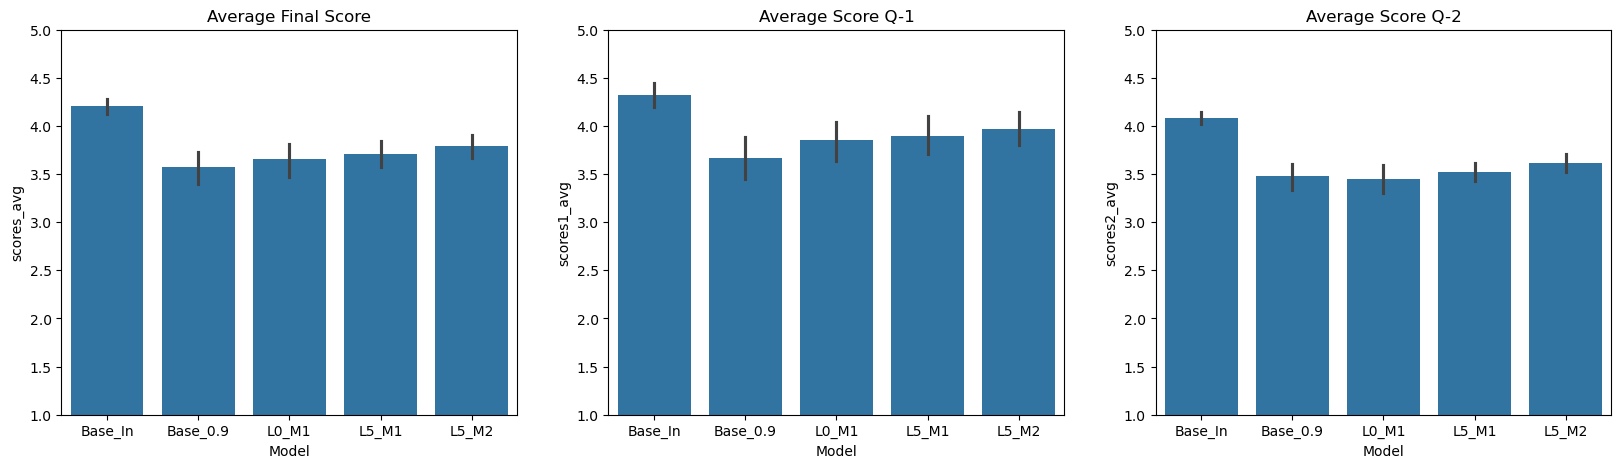

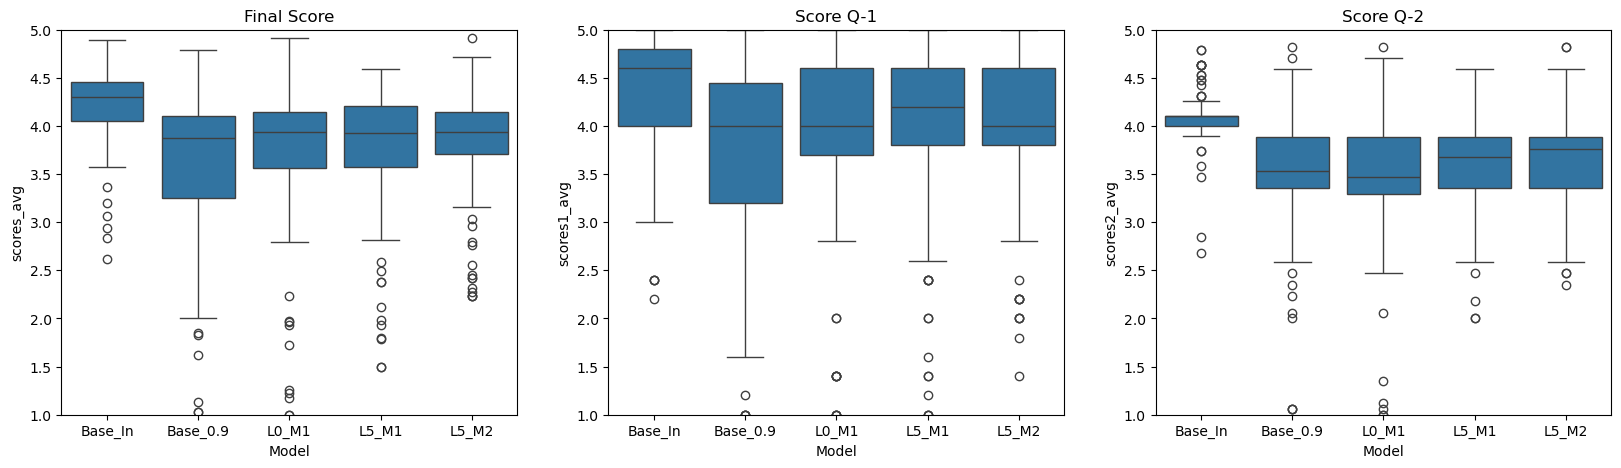

Average Scores:
             Q1     Q2  Final
Model                        
Base_0.9  3.667  3.476  3.571
Base_In   4.321  4.087  4.204
L0_M1     3.857  3.453  3.655
L5_M1     3.898  3.523  3.710
L5_M2     3.968  3.614  3.791

Standard Deviation of Scores:
             Q1     Q2  Final
Model                        
Base_0.9  1.072  0.666  0.813
Base_In   0.626  0.294  0.413
L0_M1     1.016  0.735  0.828
L5_M1     1.005  0.480  0.712
L5_M2     0.813  0.456  0.597


In [9]:
# group combined_data by model
grouped_data = combined_data.groupby("Model")

# plot the average scores for each model (scores_avg, scores1_avg, scores2_avg)
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.barplot(x="Model", y="scores_avg", data=combined_data, ax=ax[0])
sns.barplot(x="Model", y="scores1_avg", data=combined_data, ax=ax[1])
sns.barplot(x="Model", y="scores2_avg", data=combined_data, ax=ax[2])
ax[0].set_title("Average Final Score")
ax[1].set_title("Average Score Q-1")
ax[2].set_title("Average Score Q-2")
for a in ax:
    a.set_ylim(1, 5)
plt.show()

# boxplot of scores for each model
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.boxplot(x="Model", y="scores_avg", data=combined_data, ax=ax[0])
sns.boxplot(x="Model", y="scores1_avg", data=combined_data, ax=ax[1])
sns.boxplot(x="Model", y="scores2_avg", data=combined_data, ax=ax[2])
ax[0].set_title("Final Score")
ax[1].set_title("Score Q-1")
ax[2].set_title("Score Q-2")
for a in ax:
    a.set_ylim(1, 5)
plt.show()


# print table of average scores for each model and each question
avg = (combined_data.groupby("Model")[["scores1_avg", "scores2_avg", "scores_avg"]].mean().round(3))

# print std of scores for each model and each question
std = (combined_data.groupby("Model")[["scores1_avg", "scores2_avg", "scores_avg"]].std().round(3))

# in avg and std, change the column names to Q1, Q2, and Final
avg.columns = ["Q1", "Q2", "Final"]
std.columns = ["Q1", "Q2", "Final"]
print("Average Scores:")
print(avg)
print()
print("Standard Deviation of Scores:")
print(std)







In [10]:
# # check significance of the difference in scores between base and each model
# Base_names = ["Base"]
# threshold_significance = 0.05
# for Base_name in Base_names:
#     print(f"Base: {Base_name}")
#     print("=" * 50)
#     for model_name, group in grouped_data:
#         if Base_name != model_name:
#             print(f"Model: {model_name}")
#             t_stat_1, p_val_1 = stats.ttest_ind(grouped_data.get_group(Base_name)["scores1_avg"], group["scores1_avg"])
#             t_stat_2, p_val_2 = stats.ttest_ind(grouped_data.get_group(Base_name)["scores2_avg"], group["scores2_avg"])
#             t_stat_avg, p_val_avg = stats.ttest_ind(grouped_data.get_group(Base_name)["scores_avg"], group["scores_avg"])
#             print(f"Score Q-1: t-statistic = {t_stat_1}, p-value = {p_val_1}")
#             print(f"Score Q-2: t-statistic = {t_stat_2}, p-value = {p_val_2}")
#             print(f"Final Score: t-statistic = {t_stat_avg}, p-value = {p_val_avg}")
#             if p_val_1 < threshold_significance:
#                 print("Significant difference in Score Q-1")
#             if p_val_2 < threshold_significance:
#                 print("Significant difference in Score Q-2")
#             if p_val_avg < threshold_significance:
#                 print("Significant difference in Final Score")
#             print("=" * 50)

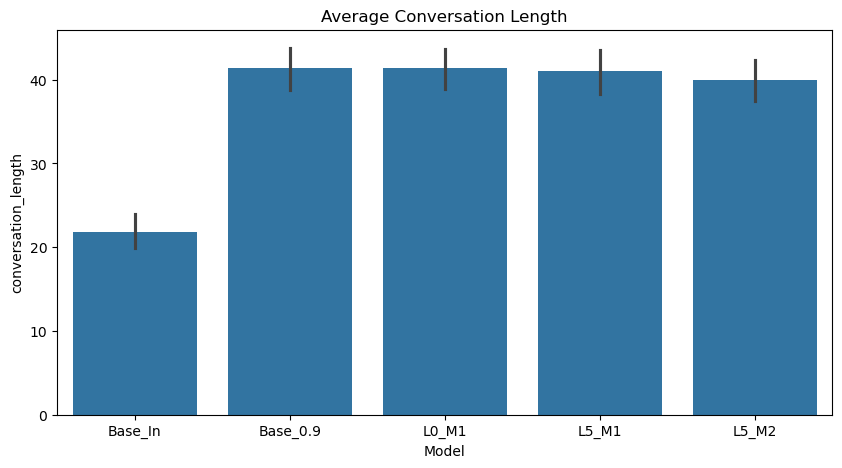

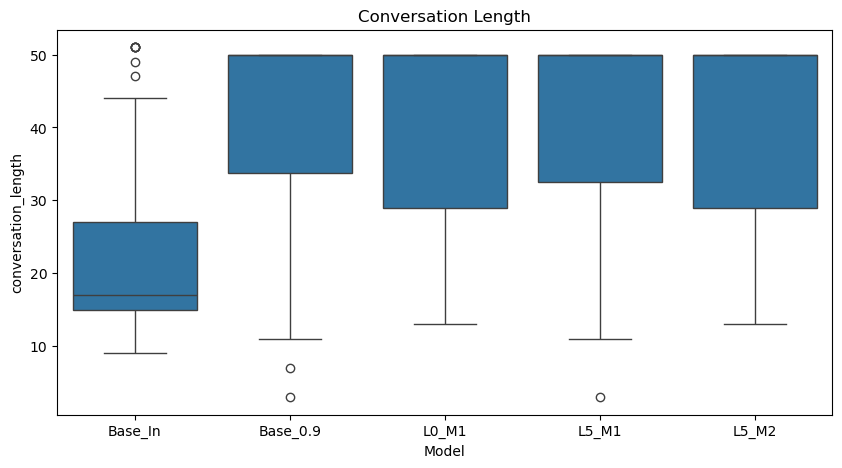

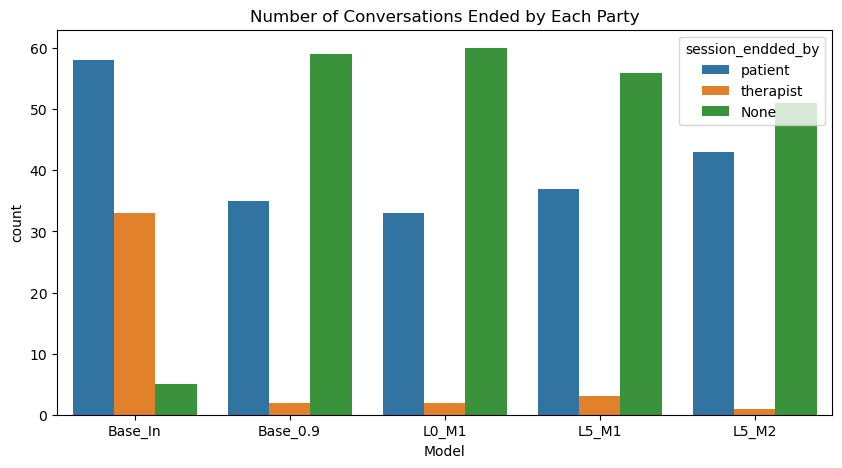

In [11]:
# plot the average conversation length for each model
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.barplot(x="Model", y="conversation_length", data=combined_data, ax=ax)
ax.set_title("Average Conversation Length")
plt.show()

# box plot of conversation length for each model
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot(x="Model", y="conversation_length", data=combined_data, ax=ax)
ax.set_title("Conversation Length")
plt.show()

# plot the number of conversations that ended with each party for each model
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(x="Model", hue="session_endded_by", data=combined_data, ax=ax)
ax.set_title("Number of Conversations Ended by Each Party")
plt.show()







In [12]:
# # show the difference in scores between conversation that ended with the therapist and those that ended with the patient and those that did not end at all. for each model separately.
# num_models = len(model_names)
# fix, ax = plt.subplots(num_models, 3, figsize=(20, 5*num_models))
# for i, (model_name, model_data) in enumerate(grouped_data):
#     sns.boxplot(x="session_endded_by", y="scores_avg", data=model_data, ax=ax[i][0])
#     sns.boxplot(x="session_endded_by", y="scores1_avg", data=model_data, ax=ax[i][1])
#     sns.boxplot(x="session_endded_by", y="scores2_avg", data=model_data, ax=ax[i][2])
#     ax[i][0].set_title(f"{model_name} - Average Score")
#     ax[i][1].set_title(f"{model_name} - Average Score 1")
#     ax[i][2].set_title(f"{model_name} - Average Score 2")
# plt.show()
    

In [13]:
threshold_score = 2

# for each model get all conversations that ended with final score below 2
bad_conversations = combined_data[combined_data["scores_avg"] <= threshold_score]
print("Total Number of bad conversations:", len(bad_conversations))
for model_name in model_names:
    model_data = combined_data[combined_data["Model"] == model_name]
    model_bad_conversations = model_data[model_data["scores_avg"] <= threshold_score]
    print(f"Number of bad conversations for {model_name}:", len(model_bad_conversations))
    bad_conversations_indices = model_bad_conversations.index
    bad_conversations_scores = (model_bad_conversations["scores_avg"], model_bad_conversations["scores1_avg"], model_bad_conversations["scores2_avg"])
    bad_conversations_scores = list(zip(*bad_conversations_scores))
    bad_conversations_scores = np.array(bad_conversations_scores)
    print("Bad Conversations indices:", bad_conversations_indices)
    print("Bad Conversations scores:", bad_conversations_scores)
    print("-"*42)
    print("\n\n")



Total Number of bad conversations: 22
Number of bad conversations for Base_In: 0
Bad Conversations indices: Index([], dtype='int64')
Bad Conversations scores: []
------------------------------------------



Number of bad conversations for Base_0.9: 7
Bad Conversations indices: Index([0, 4, 31, 39, 75, 87, 94], dtype='int64')
Bad Conversations scores: [[1.02941176 1.         1.05882353]
 [1.82941176 1.6        2.05882353]
 [1.85294118 1.         2.70588235]
 [2.         2.         2.        ]
 [1.61764706 1.         2.23529412]
 [1.12941176 1.2        1.05882353]
 [1.02941176 1.         1.05882353]]
------------------------------------------



Number of bad conversations for L0_M1: 9
Bad Conversations indices: Index([9, 13, 16, 24, 43, 47, 56, 63, 68], dtype='int64')
Bad Conversations scores: [[1.72941176 1.4        2.05882353]
 [1.96470588 1.4        2.52941176]
 [1.25882353 1.4        1.11764706]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.17647059 1.

In [14]:

# # for each model get all conversations that ended with final score below 2
# bad_conversations = combined_data[combined_data["scores1_avg"] <= threshold_score]
# print("Total Number of bad conversations:", len(bad_conversations))
# for model_name in model_names:
#     model_data = combined_data[combined_data["Model"] == model_name]
#     model_bad_conversations = model_data[model_data["scores1_avg"] <= threshold_score]
#     print(f"Number of bad conversations for {model_name}:", len(model_bad_conversations))
#     bad_conversations_indices = model_bad_conversations.index
#     bad_conversations_scores = model_bad_conversations["scores1_avg"]
#     print("Bad Conversations indices:", bad_conversations_indices)
#     print("Bad Conversations scores:", bad_conversations_scores)
#     print("-"*42)
#     print("\n\n")



In [15]:

# # for each model get all conversations that ended with final score below 2
# bad_conversations = combined_data[combined_data["scores2_avg"] <= threshold_score]
# print("Total Number of bad conversations:", len(bad_conversations))
# for model_name in model_names:
#     model_data = combined_data[combined_data["Model"] == model_name]
#     model_bad_conversations = model_data[model_data["scores2_avg"] <= threshold_score]
#     print(f"Number of bad conversations for {model_name}:", len(model_bad_conversations))
#     bad_conversations_indices = model_bad_conversations.index
#     bad_conversations_scores = model_bad_conversations["scores2_avg"]
#     print("Bad Conversations indices:", bad_conversations_indices)
#     print("Bad Conversations scores:", bad_conversations_scores)
#     print("-"*42)
#     print("\n\n")

